In [21]:
from pathlib import Path
import os, random, shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import imagehash
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

BASE = Path("data/Mushrooms")  # adjust if needed
assert BASE.exists(), f"Folder not found: {BASE.resolve()}"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}


# Data exploration and visualization

In [12]:
species = sorted([d.name for d in BASE.iterdir() if d.is_dir()])
counts = {c: sum(1 for p in (BASE/c).glob("*.*") if p.suffix.lower() in IMG_EXTS) for c in species}
df_counts = (
    pd.DataFrame({"class": list(counts.keys()), "count": list(counts.values())})
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)
display(df_counts.head(20))
print(f"Total species: {len(species)}, total images: {df_counts['count'].sum()}")


class  count
0    Lactarius   1563
1      Russula   1148
2      Boletus   1073
3  Cortinarius    836
4      Amanita    750
5     Entoloma    364
6     Agaricus    353
7    Hygrocybe    316
8      Suillus    311

Total species: 9, total images: 6714


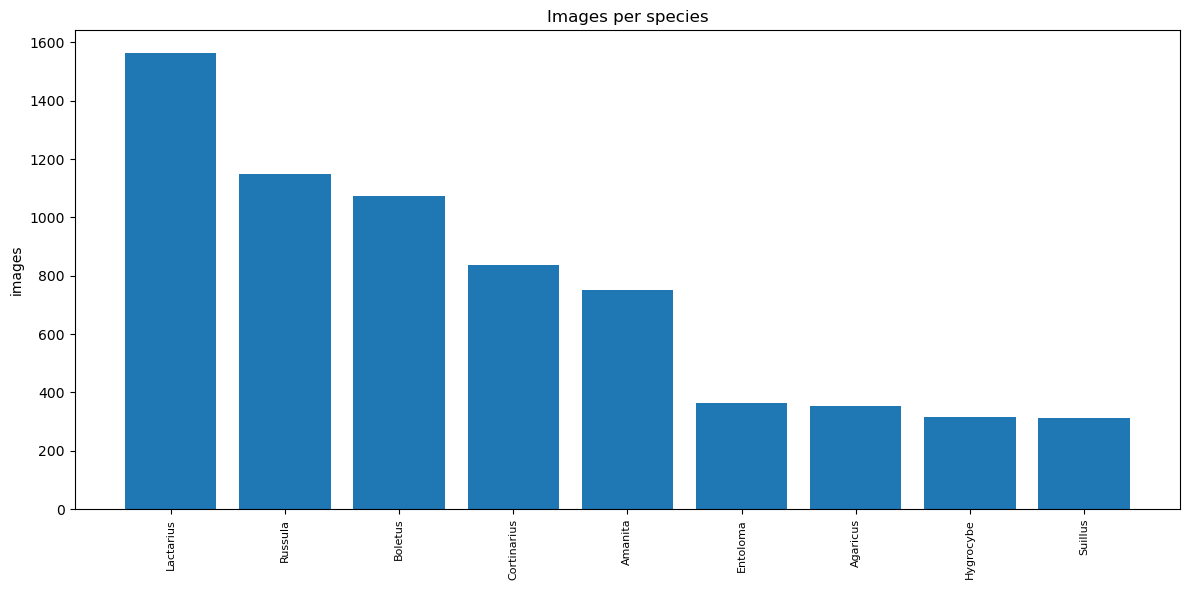

In [13]:
# Bar plot (may be wide if many species)
plt.figure(figsize=(12, 6))
plt.bar(df_counts["class"], df_counts["count"])
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("images")
plt.title("Images per species")
plt.tight_layout()
plt.show()


In [15]:
classes = df_counts["class"].tolist()
len(classes), classes


(9,
 ['Lactarius',
  'Russula',
  'Boletus',
  'Cortinarius',
  'Amanita',
  'Entoloma',
  'Agaricus',
  'Hygrocybe',
  'Suillus'])

In [16]:
rows = []
for c in classes:
    for p in (BASE/c).glob("*.*"):
        if p.suffix.lower() in IMG_EXTS:
            rows.append({"path": str(p), "label": c})
df = pd.DataFrame(rows)
df.sample(5)
print("Images per species:\n", df["label"].value_counts().head(12))


Images per species:
 label
Lactarius      1563
Russula        1148
Boletus        1073
Cortinarius     836
Amanita         750
Entoloma        364
Agaricus        353
Hygrocybe       316
Suillus         311
Name: count, dtype: int64


Suillus 311 images


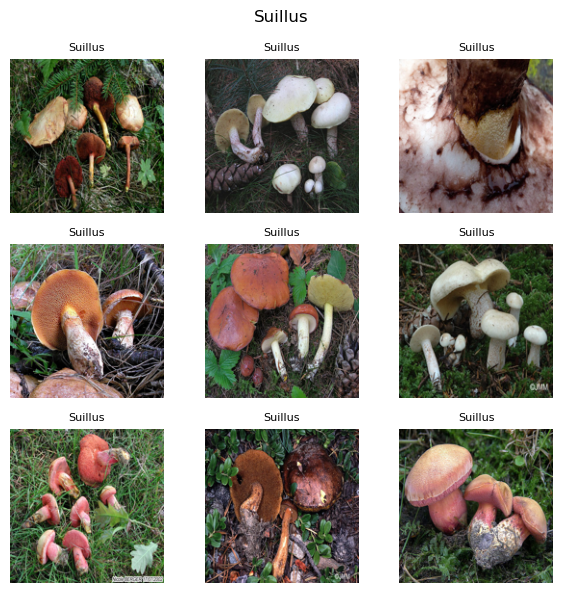

Agaricus 353 images


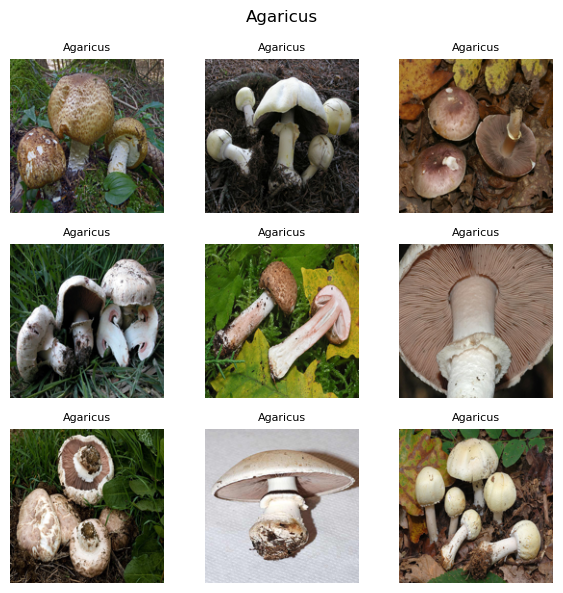

Lactarius 1563 images


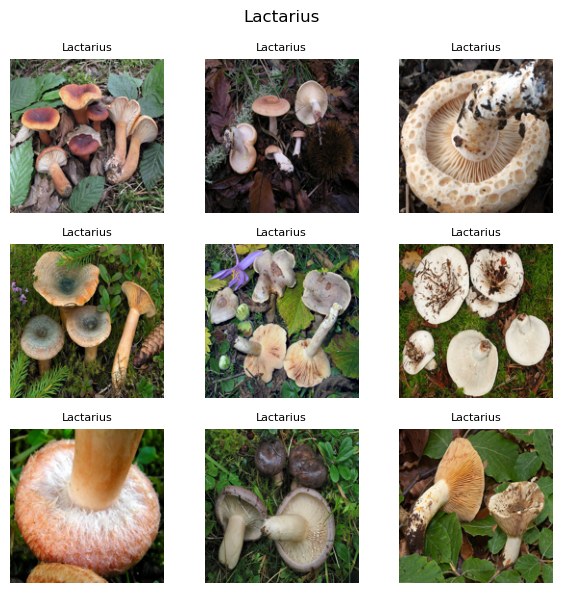

Cortinarius 836 images


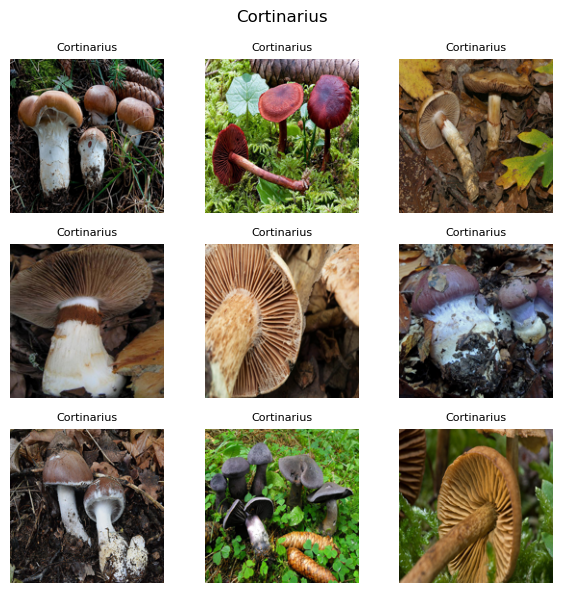

Hygrocybe 316 images


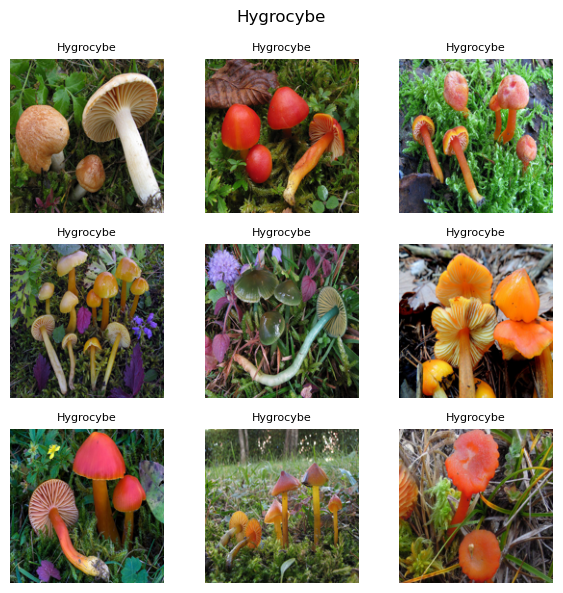

Entoloma 364 images


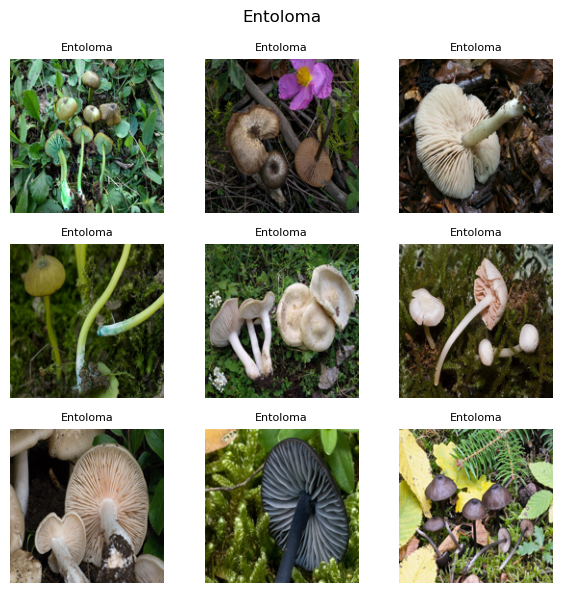

In [ ]:
def show_grid(paths, n=16, size=128, title=None):
    picks = random.sample(paths, min(n, len(paths)))
    cols = int(np.sqrt(n)); rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i, p in enumerate(picks):
        img = Image.open(p).convert("RGB").resize((size, size))
        plt.subplot(rows, cols, i+1)
        plt.imshow(img); plt.axis("off"); plt.title(Path(p).parent.name[:18], fontsize=8)
    if title: plt.suptitle(title)
    plt.tight_layout(); plt.show()

for c in random.sample(classes, len(classes)):
    paths = df[df.label==c]["path"].tolist()
    print(c, len(paths), "images")
    show_grid(paths, n=9, size=160, title=c)


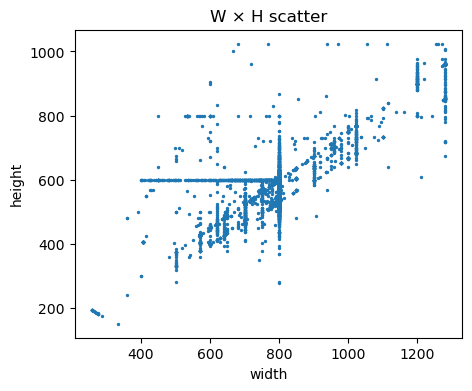

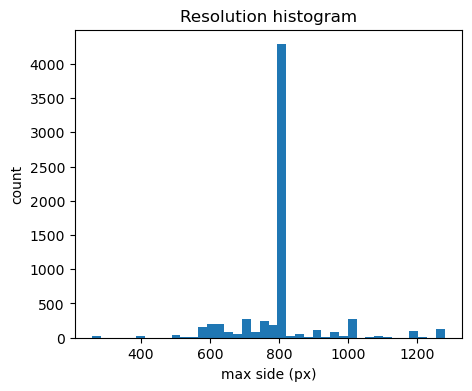

In [ ]:
def get_wh(p):
    try:
        with Image.open(p) as im:
            return im.size  # (W, H)
    except Exception:
        return None

dims = df["path"].apply(get_wh)
df["w"] = [d[0] if d else None for d in dims]
df["h"] = [d[1] if d else None for d in dims]
df_clean = df.dropna(subset=["w","h"])

plt.figure(figsize=(5,4))
plt.scatter(df_clean["w"], df_clean["h"], s=2)
plt.xlabel("width")
plt.ylabel("height")
plt.title("W × H scatter")
plt.show()

plt.figure(figsize=(5,4))
plt.hist(np.maximum(df_clean["w"], df_clean["h"]), bins=40)
plt.xlabel("max side (px)")
plt.ylabel("count")
plt.title("Resolution histogram")
plt.show()


# Data split

In [19]:
# Unique classes (works with 9 or 12+)
classes = sorted(df['label'].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
num_classes = len(classes)

# Encode labels
df['y'] = df['label'].map(class_to_idx)

# (Re)create splits if needed; otherwise, reuse your existing `train/val/test` dataframes
from sklearn.model_selection import train_test_split
if 'split' not in df.columns:
    train_df, tmp_df = train_test_split(df, test_size=0.30, stratify=df['y'], random_state=42)
    val_df,  test_df = train_test_split(tmp_df, test_size=0.50, stratify=tmp_df['y'], random_state=42)
else:
    train_df = df[df.split=='train']; val_df = df[df.split=='val']; test_df = df[df.split=='test']

print(len(train_df), len(val_df), len(test_df), num_classes)


4699 1007 1008 9


In [20]:
# Counts
train_counts = train_df['y'].value_counts().sort_index().to_numpy()
print("Train counts per class:", train_counts)

# Class weights for loss: inverse frequency normalized
total = train_counts.sum()
class_weights = {i: (total / (num_classes * cnt)) for i, cnt in enumerate(train_counts)}
class_weights


Train counts per class: [ 247  525  751  585  255  221 1094  803  218]


{0: 2.1138101664417452,
 1: 0.9944973544973545,
 2: 0.69522118656606,
 3: 0.8924976258309592,
 4: 2.0474945533769064,
 5: 2.362493715434892,
 6: 0.47724964452569574,
 7: 0.6502006365020063,
 8: 2.3950050968399594}

# Config

In [66]:
IMG_SIZE = 128        # try 128 first; bump to 160 (or 192) if need more detail
BATCH    = 32
SEED     = 42
MODEL_CHOICE = "mbv2"   # "mbv2" or "dscnn"
USE_PRETRAINED = True   # use ImageNet weights for mbv2 (better accuracy). Falls back to None if unavailable.


AUTOTUNE = tf.data.AUTOTUNE


# Augmentation and loader

In [67]:
def load_img(path, label, training=True):
    img = tf.io.read_file(path)
    # decode both JPEG/PNG (will throw on corrupt JPEGs)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Guard against zero-sized decodes (corrupt files)
    shape = tf.shape(img)
    h, w = shape[0], shape[1]
    # If either dimension is 0, raise an error that ignore_errors() will skip
    tf.debugging.assert_positive(h, message="Bad image height")
    tf.debugging.assert_positive(w, message="Bad image width")

    # center-crop to square, then resize
    s = tf.minimum(h, w)
    img = tf.image.crop_to_bounding_box(img, (h - s) // 2, (w - s) // 2, s, s)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.08)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_saturation(img, 0.9, 1.1)
        img = tf.image.random_hue(img, 0.02)
        
    if MODEL_CHOICE == "mbv2" and USE_PRETRAINED:
        img = img * 255.0

    return img, label


In [68]:
def make_eval_ds(frame):
    ds = tf.data.Dataset.from_tensor_slices((frame['path'].tolist(), frame['y'].tolist()))
    ds = ds.map(lambda p,y: load_img(p,y,training=False), num_parallel_calls=AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())   # skip corrupt eval files
    return ds.batch(BATCH).prefetch(AUTOTUNE)


In [69]:
# Balanced train sampler (oversampling)
per_class_datasets, weights = [], []
for cls_idx in range(num_classes):
    paths = train_df[train_df['y'] == cls_idx]['path'].tolist()
    labels = [cls_idx] * len(paths)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(min(1000, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.repeat()
    ds = ds.map(lambda p,y: load_img(p,y, training=True), num_parallel_calls=AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    per_class_datasets.append(ds)

    # inverse-frequency weight
    cnt = max(1, len(paths))
    weights.append(1.0 / cnt)

weights = np.asarray(weights, np.float32); weights /= weights.sum()
balanced_train = tf.data.Dataset.sample_from_datasets(per_class_datasets, weights=list(weights), seed=SEED)
balanced_train = balanced_train.batch(BATCH).prefetch(AUTOTUNE)

val_ds  = make_eval_ds(val_df)
test_ds = make_eval_ds(test_df)

# Use a safer steps/epoch: roughly 1 pass over the real training set per epoch
import math
steps_per_epoch = max(1, math.ceil(len(train_df) / BATCH))
validation_steps = max(1, math.ceil(len(val_df) / BATCH))
print("steps_per_epoch:", steps_per_epoch, "validation_steps:", validation_steps)


steps_per_epoch: 147 validation_steps: 32


# Models

In [75]:
def make_mbv2_tiny(num_classes=num_classes, img_size=IMG_SIZE, alpha=0.35, pretrained=USE_PRETRAINED):
    weights = "imagenet" if pretrained else None
    base = keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights=weights,
        alpha=alpha
    )
    preprocess = keras.applications.mobilenet_v2.preprocess_input  # expects [0,255]

    base.trainable = False if weights == "imagenet" else True

    inp = keras.Input((img_size, img_size, 3))
    x = preprocess(inp)                         # now correct because loader sends [0,255] when pretrained
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out)

    # Label smoothing can stabilize on imbalanced data
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model, base


In [76]:
def make_dscnn_tiny(num_classes=num_classes, img_size=IMG_SIZE, ch=24):
    inp = keras.Input((img_size, img_size, 3))
    x = layers.Conv2D(ch, 3, strides=2, padding="same", use_bias=False)(inp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    def dw(x, c_out, s):
        x = layers.DepthwiseConv2D(3, strides=s, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = layers.Conv2D(c_out, 1, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        return x

    x = dw(x, ch,   1)
    x = dw(x, ch*2, 2)
    x = dw(x, ch*2, 1)
    x = dw(x, ch*4, 2)
    x = dw(x, ch*4, 1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [77]:
# Instantiate
if MODEL_CHOICE == "mbv2":
    model, base = make_mbv2_tiny()
else:
    model = make_dscnn_tiny()

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_7 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_7 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_128            │ (None, 4, 4, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,737 (1.61 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 410,208 (1.56 MB)

# Train

In [78]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

# Warmup a few epochs (if mbv2 pretrained & frozen)
epochs_warmup = 5 if (MODEL_CHOICE == "mbv2" and USE_PRETRAINED) else 0
if epochs_warmup > 0:
    history1 = model.fit(
        balanced_train,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs_warmup,
        validation_data=val_ds,
        validation_steps=validation_steps,
        # If you skip oversampling, you can use the class_weight below instead:
        # class_weight=class_weights,
        callbacks=callbacks
    )
    # unfreeze last N layers and fine-tune
    for layer in base.layers[-60:]:
        layer.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(3e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.3806 - loss: 1.8744 - val_accuracy: 0.3883 - val_loss: 1.6534
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.6289 - loss: 1.0992 - val_accuracy: 0.4359 - val_loss: 1.5309
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.6934 - loss: 0.9051 - val_accuracy: 0.4657 - val_loss: 1.4510
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.7369 - loss: 0.8056 - val_accuracy: 0.4816 - val_loss: 1.4697
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7584 - loss: 0.7492 - val_accuracy: 0.5214 - val_loss: 1.3512


In [79]:
# Main training
history2 = model.fit(
    balanced_train,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.6419 - loss: 1.0577 - val_accuracy: 0.4071 - val_loss: 2.0028
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.8246 - loss: 0.5453 - val_accuracy: 0.4479 - val_loss: 1.9350
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8652 - loss: 0.4236 - val_accuracy: 0.5055 - val_loss: 1.6501
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9041 - loss: 0.3059 - val_accuracy: 0.5551 - val_loss: 1.4691
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.9158 - loss: 0.2570 - val_accuracy: 0.5611 - val_loss: 1.4666
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9278 - loss: 0.2289 - val_accuracy: 0.6097 - val_loss: 1.3107
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9248 - loss: 0.2210 - val_accuracy: 0.5929 - val_loss: 1.3827
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9509 - loss: 0

In [83]:
# ========= Evaluate =========
test_metrics = model.evaluate(test_ds)
print("Test:", dict(zip(model.metrics_names, test_metrics)))
test_accuracy = test_metrics[1]


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7107 - loss: 1.0329
Test: {'loss': 1.0334919691085815, 'compile_metrics': 0.6904761791229248}


c:\Users\adamk\anaconda3\envs\micro_speech_model_maker\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Quantize

In [87]:
# --- 1) Wrap trained float model with a uint8 input (Keras-friendly cast) ---
inp_uint8 = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype="uint8", name="input_uint8")
x = keras.layers.Lambda(lambda t: tf.cast(t, tf.float32), name="cast_to_float32")(inp_uint8)
wrapped_uint8_model = keras.Model(inp_uint8, model(x), name="wrapped_uint8")

wrapped_uint8_model.summary()

# --- 2) Helper: safe center-crop + resize with PIL (no TF decoders here) ---
def pil_center_square_resize(img: Image.Image, out=IMG_SIZE) -> Image.Image:
    w, h = img.size
    s = min(w, h)
    left = (w - s) // 2
    top  = (h - s) // 2
    img = img.crop((left, top, left + s, top + s))
    return img.resize((out, out), Image.BILINEAR)

# --- 3) Build a list of "good" image paths (optional quick verification) ---
def filter_good_paths(paths, max_check=2000):
    good = []
    for p in paths[:max_check]:
        try:
            with Image.open(p) as im:
                im.verify()  # lightweight integrity check
            good.append(p)
        except Exception:
            continue
    return good

# Prefer training images for calibration
all_train_paths = train_df['path'].tolist()
# Shuffle deterministically so we don't always check the same ones
rng = np.random.default_rng(0)
rng.shuffle(all_train_paths)
good_paths = filter_good_paths(all_train_paths, max_check=min(5000, len(all_train_paths)))
if not good_paths:
    # fallback: try val set
    val_paths = val_df['path'].tolist()
    rng.shuffle(val_paths)
    good_paths = filter_good_paths(val_paths, max_check=min(5000, len(val_paths)))
assert len(good_paths) > 0, "No valid images found for calibration."

# --- 4) Representative dataset: yield uint8 batches; skip any that fail at runtime ---
def rep_data_gen():
    sampleN = min(300, len(good_paths))
    for p in good_paths[:sampleN]:
        try:
            with Image.open(p) as im:
                im = im.convert("RGB")
                im = pil_center_square_resize(im, IMG_SIZE)
                arr = np.asarray(im, dtype=np.uint8)           # HxWx3, uint8 [0..255]
                arr = np.expand_dims(arr, 0)                   # 1xHxWx3
                yield [arr]
        except Exception:
            # Skip any image that fails to open/resize
            continue

# --- 5) Full-integer INT8 with uint8 I/O ---
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_uint8_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()
out_path = f"mushroom_{test_accuracy:.2f}_{IMG_SIZE}_{MODEL_CHOICE}_int8.tflite"
Path(out_path).write_bytes(tflite_int8)
print("Wrote", out_path, "size:", len(tflite_int8)/1024, "KB")


Model: "wrapped_uint8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_uint8 (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (Lambda)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 9)              │       421,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,737 (1.61 MB)

 Trainable params: 356,873 (1.36 MB)

 Non-trainable params: 64,864 (253.38 KB)

INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpa6g60itn\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpa6g60itn\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpa6g60itn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name='input_uint8')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  2734926358352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926359696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926360272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926359888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926358928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926361616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926362000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926362384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926362192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2734926357968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  27349263

c:\Users\adamk\anaconda3\envs\micro_speech_model_maker\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Wrote mushroom_0.69_128_mbv2_int8.tflite size: 617.1640625 KB
